#Ajustando as importação dos dados

#Conexao com o Kaggle

In [15]:
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch
from skimage import io
import random
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models




In [2]:
from google.colab import files

In [75]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinciuspimpim","key":"138e866b6eec44ffb2e9654660eac692"}'}

In [5]:
pip install kaggle -q

In [6]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
%cd /content/
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

/content
100% 2.29G/2.29G [00:20<00:00, 144MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip -d XrayPneumonia

#Transformando os dados em csv

In [78]:
import os
import csv

def criar_csv(diretorio_raiz, pasta):
    caminho_pasta = os.path.join(diretorio_raiz, pasta)
    dados = []

    for classe in os.listdir(caminho_pasta):
        caminho_classe = os.path.join(caminho_pasta, classe)
        if os.path.isdir(caminho_classe):  # Verifica se é um diretório
            for nome_arquivo in os.listdir(caminho_classe):
                if nome_arquivo != '.DS_Store':  # Ignora o arquivo .DS_Store
                    dados.append((nome_arquivo, classe))

    nome_arquivo_csv = f'dados_{pasta}.csv'

    with open(nome_arquivo_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['nome_da_imagem', 'Classe'])
        writer.writerows(dados)

    print(f'Arquivo CSV "{nome_arquivo_csv}" criado com sucesso!')

diretorio_raiz = '/content/XrayPneumonia/chest_xray/chest_xray'
pastas = ['train', 'test','val']

for pasta in pastas:
    criar_csv(diretorio_raiz, pasta)



Arquivo CSV "dados_train.csv" criado com sucesso!
Arquivo CSV "dados_test.csv" criado com sucesso!
Arquivo CSV "dados_val.csv" criado com sucesso!


#Transformando dados em dataframe

                nome_da_imagem  Classe
4294  person368_virus_748.jpeg       1


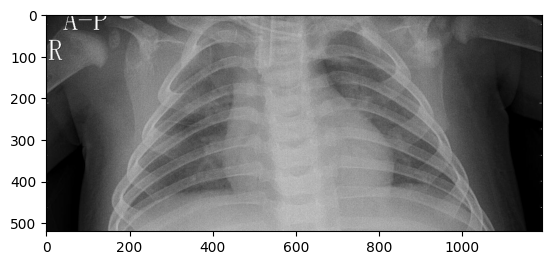

In [96]:
Train_data = pd.read_csv('/content/dados_train.csv')
Test_data = pd.read_csv('/content/dados_test.csv')
Val_data = pd.read_csv('/content/dados_val.csv')

data = [Train_data,Test_data,Val_data]

issue = {'NORMAL':0, 'PNEUMONIA':1}

#substituindo para valor
for classes in data:
  classes['Classe'] = classes['Classe'].map(issue)

Train_data['nome_da_imagem']

resultado = Train_data[Train_data['nome_da_imagem'] == 'person368_virus_748.jpeg']

print(resultado)

img = cv2.imread('/content/XrayPneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1799_bacteria_4647.jpeg')
plt.imshow(img)


#Funcoes para o pythorch

In [117]:
import os

class XrayPneumonia(Dataset):
    def __init__(self, annotations_file_Dataframe, img_dirs, transform= None, target_transform=None):
        self.img_labels = annotations_file_Dataframe
        self.img_dirs = img_dirs  # Inicialmente, temos apenas um diretório
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, self.img_labels.iloc[idx, 0])
            if os.path.exists(img_path) == True:
              image = read_image(img_path)
              label = self.img_labels.iloc[idx, 1]
              if self.transform:
                    image = self.transform(image)
              if self.target_transform:
                    label = self.target_transform(label)
        return image, label





In [1]:
training_data = XrayPneumonia(Train_data, ['/content/XrayPneumonia/chest_xray/chest_xray/train/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/train/PNEUMONIA'],transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona a imagem para 256x256 pixels
    transforms.CenterCrop(224),  # Corta o centro da imagem para obter 224x224 pixels
]))

training_data.shape()

test_data = XrayPneumonia(Test_data, ['/content/XrayPneumonia/chest_xray/chest_xray/test/NORMAL','/content/XrayPneumonia/chest_xray/chest_xray/test/PNEUMONIA'],transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona a imagem para 256x256 pixels
    transforms.CenterCrop(224),  # Corta o centro da imagem para obter 224x224 pixels
]))




print(training_data.shape())


NameError: name 'XrayPneumonia' is not defined

In [127]:
print(type(training_data))

<class '__main__.XrayPneumonia'>


In [142]:
from torch.utils.data import DataLoader


dataloaders = {'train' : DataLoader(training_data, batch_size=4, shuffle=True, num_workers = 2) , 'test' : DataLoader(test_data, batch_size=4, shuffle=True, num_workers = 2) }
dataset_sizes = {'train' : len(Train_data) , 'test' : len(Test_data)}


#img, label = training_data.__getitem__(12)



#img.permute(1,2,0)
#plt.imshow(img.permute(1,2,0))






In [ ]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [73]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [143]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[4, 1, 224, 224] to have 3 channels, but got 1 channels instead